
# Assignment 1: Exploring Word Embeddings
**Course Name:** Natural Language Processing (CSC6052/5051/4100/DDA6307/MDS5110)





*Please enter your personal information (make sure you have copied this colab)*

**Name:** Chua Qin Di

**Student ID:** 125400010






## Assignment Requirements

This Colab file includes all contents for Assignment 1.

#### You are required to:
Some sections of the code are incomplete and require your input, especially pay attention to the parts marked with **<font color="red">[Task]</font>**. These sections are critical for scoring the assignment.

## Submission Guidelines
Follow these steps to submit your assignment:
**Upload Your File:** Access the [Blackboard system](https://bb.cuhk.edu.cn/) and upload your `.ipynb` file.


## Overview

*Assignment 1* consists of two tasks:
- Task 1: Train Word Embeddings with Word2Vec (5 points)
- Task 2: Explore word embeddings (3 ponits)
- Task 3: Utilize word embeddings (2 points)

Your task is to **run all the code in this script** and complete the parts marked with <font color="red">[task]</font>.

## Prerequisite
If you're new to Python, Numpy, or PyTorch, consider these tutorials for a quick start:
- [Python-Numpy-Tutorial](https://cs231n.github.io/python-numpy-tutorial/)
- [Introduction to PyTorch](https://colab.research.google.com/drive/1obAmmGHsMizB38aiZJ_-L1bVMT5KOLMd?usp=sharing)

## Task 1: Train Word Embeddings with Word2Vec

**In this task, you will implement and train your own Word2Vec model.**

Before diving in, let's clarify what Word2Vec is.

Its core concept is straightforward: you can infer the meaning of a word from its neighbors - the words that frequently appear in the same context. Consider this illustration:
![Contexts](https://image.ibb.co/mnQ2uz/2018_09_17_21_07_08.png)

A basic approach is to use the context word counts as meaningful word vectors. Take this simple corpus for example:

```
The red fox jumped
The brown fox jumped
```

The count vectors would look like this:
```
        the fox jumped red brown
red   = (1   1    1     0    0)
brown = (1   1    1     0    0)
```

Notice how `red` and `brown` have similar vectors! We're close to solving the problem, but the goal is to obtain more compact embedding vectors.

This is where Word2Vec algorithms come into play. They construct embedding vectors based on the word's neighbors in the corpus.

For a more detailed introduction, check out this post: [king - man + woman = queen; but why?](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html).

Let's do some preparation work before moving to the interesting stuff.



### **1.1 Preparation**

Environment installation and data download

In [1]:
## python 3.10
!pip -qq install torch==1.11
!pip -qq install matplotlib
!pip -qq install pandas
!pip -qq install scikit-learn
!pip -qq install nltk==3.8
!pip -qq install gensim
!pip -qq install bokeh==3.2.0

!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip -o quora.zip

import nltk
nltk.download('punkt')
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
%matplotlib inline
np.random.seed(42)

import pandas as pd
from nltk.tokenize import word_tokenize
from tqdm import tqdm


Archive:  quora.zip
  inflating: train.csv               


[nltk_data] Downloading package punkt to /Users/chuaqindi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Tokenize and lower-case texts.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())
texts = texts[:50000] # Accelerated operation
print(len(texts))

tokenized_texts = [word_tokenize(text.lower()) for text in tqdm(texts)]

assert len(tokenized_texts) == len(texts)
assert isinstance(tokenized_texts[0], list)
assert isinstance(tokenized_texts[0][0], str)

50000


100%|██████████| 50000/50000 [00:02<00:00, 24439.27it/s]


In [3]:
tokenized_texts[0]

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

2. Collect the indices of the words:

In [4]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break

    word2index[word] = len(word2index)

index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]

print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 7226
Tokens count: 623563
Unknown tokens appeared: 35607
Most freq words: ['?', 'the', 'what', 'is', 'how', 'i', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', ',', 'you', 'why', 'it', 'best']


3. collect the context words

First of all, we need to collect all the contexts from our corpus.

In [5]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1)
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))

    return contexts

contexts = build_contexts(tokenized_texts, window_size=2)

Check, what you got:

In [6]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

4. Convert to indices

Let's convert words to indices:

In [7]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context])
            for central_word, context in contexts]

### **1.2 Continuous Bag of Words (CBoW) Word2vec**

We have learn skip-gram model in tutorial. Now, we will explore another popular Word2Vec paradigm called Continuous Bag of Words (CBoW). *CBoW* offers faster processing and slightly better accuracy for common words compared to the *Skip-Gram*, which is more effective with rare words.

**CBoW Structure**

Below is the CBoW model architecture:

![](https://i.ibb.co/StXTMFH/CBOW.png)

In CBoW, the goal is to predict a target word from its surrounding context, represented by the sum of context vectors.

We will leverage our understanding from the *Skip-Gram* model to implement *CBoW*.

1. **Batches Generations**
**<font color="red">[Task]</font>** : Implement the batch generator.

**Hint**: The generator should produce a input matrix `(batch_size, 2 * window_size)` containing context word indices and a target matrix `(batch_size)` with central word indices.

In [8]:
def make_cbow_batches_iter(contexts, window_size, batch_size):

    central_words = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])
    contexts = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])


    batches_count = int(math.ceil(len(contexts) / batch_size))

    print('Initializing batches generator with {} batches per epoch'.format(batches_count))

    indices = np.arange(len(contexts))
    np.random.shuffle(indices)

    for i in range(batches_count):
      batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
      batch_indices = indices[batch_begin: batch_end]

      # ------------------
      # Write your implementation here.

      yield {
        'tokens': torch.LongTensor(contexts[batch_indices]),  # input = context
        'labels': torch.LongTensor(central_words[batch_indices]) # output = central word
      }
      # ------------------

Check it:

In [9]:
window_size = 2
batch_size = 32

batch = next(make_cbow_batches_iter(contexts, window_size=window_size, batch_size=batch_size))

assert isinstance(batch, dict)
assert 'labels' in batch and 'tokens' in batch

assert isinstance(batch['tokens'], torch.LongTensor)
assert isinstance(batch['labels'], torch.LongTensor)

assert batch['tokens'].shape == (batch_size, 2 * window_size)
assert batch['labels'].shape == (batch_size,)

Initializing batches generator with 12380 batches per epoch


2. **Model**
**<font color="red">[Task]</font>**: Build the `CBoWModel`.

**Hint**: You need to implement the `forward` method based on the CBoW architecture. The context embedding is represented as the average of their context embeddings.

In [10]:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        # ------------------
        # Write your implementation here.
        context_embedded = self.embeddings(inputs)
        context_mean = torch.mean(context_embedded, dim=1)
        return self.out_layer(context_mean)
        # ------------------

Check it:

In [11]:
model = CBoWModel(vocab_size=len(word2index), embedding_dim=32).to(device)

outputs = model(batch['tokens'].to(device))

assert isinstance(outputs, torch.FloatTensor)
assert outputs.shape == (batch_size, len(word2index))

3. **Training**
**<font color="red">[Task]</font>** : Train the CBoW.

**Hint**: Consider referring to the training code of the previously mentioned *Skip-gram* model.

In [12]:
# Here are the hyperparameters you can adjust
embedding_dim = 32
learning_rate = 0.001
epoch_num = 4
batch_size = 128

# Initialization Model
model = CBoWModel(len(word2index),embedding_dim)
# Getting model to GPU
model.to(device)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_every_nsteps = 3000
total_loss = 0
start_time = time.time()
global_step = 0

for ep in range(epoch_num):
  for step, batch in enumerate(make_cbow_batches_iter(contexts, window_size=2, batch_size=batch_size)):
      global_step += 1

      # ------------------
      # Write your implementation here.
      
      # getting data to GPU / CPU
      tokens, labels = batch['tokens'].to(device), batch['labels'].to(device)

      # forward pass
      logits = model(tokens)

      # backward pass
      loss = criterion(logits, labels)
      loss.backward()

      # apply optimizer
      optimizer.step()

      # zero grads
      optimizer.zero_grad()
      # ------------------

      total_loss += loss.item()

      if global_step != 0 and global_step % loss_every_nsteps == 0:
          print("Epoch = {}, Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(ep, step, total_loss / loss_every_nsteps,
                                                                      time.time() - start_time))
          total_loss = 0
          start_time = time.time()

Initializing batches generator with 3095 batches per epoch
Epoch = 0, Step = 2999, Avg Loss = 6.4777, Time = 12.16s
Initializing batches generator with 3095 batches per epoch
Epoch = 1, Step = 2904, Avg Loss = 5.5398, Time = 12.52s
Initializing batches generator with 3095 batches per epoch
Epoch = 2, Step = 2809, Avg Loss = 5.2259, Time = 11.98s
Initializing batches generator with 3095 batches per epoch
Epoch = 3, Step = 2714, Avg Loss = 5.0326, Time = 12.01s


**Obtaining word embeddings**

Word embeddings are contained within the embeddings layer of the model. We just need to move them from the GPU to the CPU and convert them to a numpy array.

In [13]:
embeddings = model.embeddings.weight.data.cpu().numpy()


**Testing Trained Word Embeddings**

Let's check how adequate are similarities that the model learnt.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]

    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]

    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings, index2word, word2index, 'my')

['my',
 'your',
 'electrons',
 'easy',
 'bots',
 'seals',
 'quora',
 'burning',
 'neither',
 'ovulation']

**Visualization of our embeddings**

In [15]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=1)
    return scale(tsne.fit_transform(word_vectors))


def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]

    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='blue', token=words)


visualize_embeddings(embeddings, index2word, 100)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 4.141736
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.198814
[t-SNE] KL divergence after 850 iterations: 0.584582


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:284: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Loading BokehJS ...

## Task 2： Explore Word Embeddings with Word2Vec
In this task, we shall explore the embeddings produced by word2vec. Please revisit the lecture slides or tutorials for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the original [paper](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

In [16]:
def load_word2vec():
    """ Load GloVe Twitter Vectors
        Return:
            wv_from_bin: Pre-trained embeddings with 25 dimensions for 1.2M vocabulary.
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-twitter-25")
    vocab = list(wv_from_bin.key_to_index.keys())  # Updated for Gensim 4.x
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [17]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 1193514



**Reducing dimensionality of Word2Vec Word Embeddings**

Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

- Put the 1.2 million word2vec vectors into a matrix M
- Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 25-dimensional to 2-dimensional.



In [18]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 1.2 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

**Implement reduce_to_k_dim**

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**<font color="red">[Task]</font>**: Complete reduce_to_k_dim function

In [19]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.
    SVD = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = SVD.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [39]:
# -----------------------------------------------------------------
# Run Cell to Reduce 25-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...


/var/folders/cr/rc66z7ts2qn1q0_v4n58rbt40000gn/T/ipykernel_97765/3415616940.py:20: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))
/var/folders/cr/rc66z7ts2qn1q0_v4n58rbt40000gn/T/ipykernel_97765/3415616940.py:27: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))


Done.


**Here is a helper function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).**

In [40]:
import matplotlib.pyplot as plt

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus, k)): matrix of k-dimensional word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    plt.figure(figsize=(10, 10))
    for word in words:
        if word in word2Ind:
            idx = word2Ind[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y, marker='o', color='blue')
            plt.text(x + 0.02, y + 0.02, word, fontsize=9)
        else:
            print(f"Word '{word}' not found in word2Ind dictionary.")

    plt.title("Word Embeddings Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

### 2.1: Word2Vec Plot Analysis
Run the cell below to plot the 2D word2vec embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela'].

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

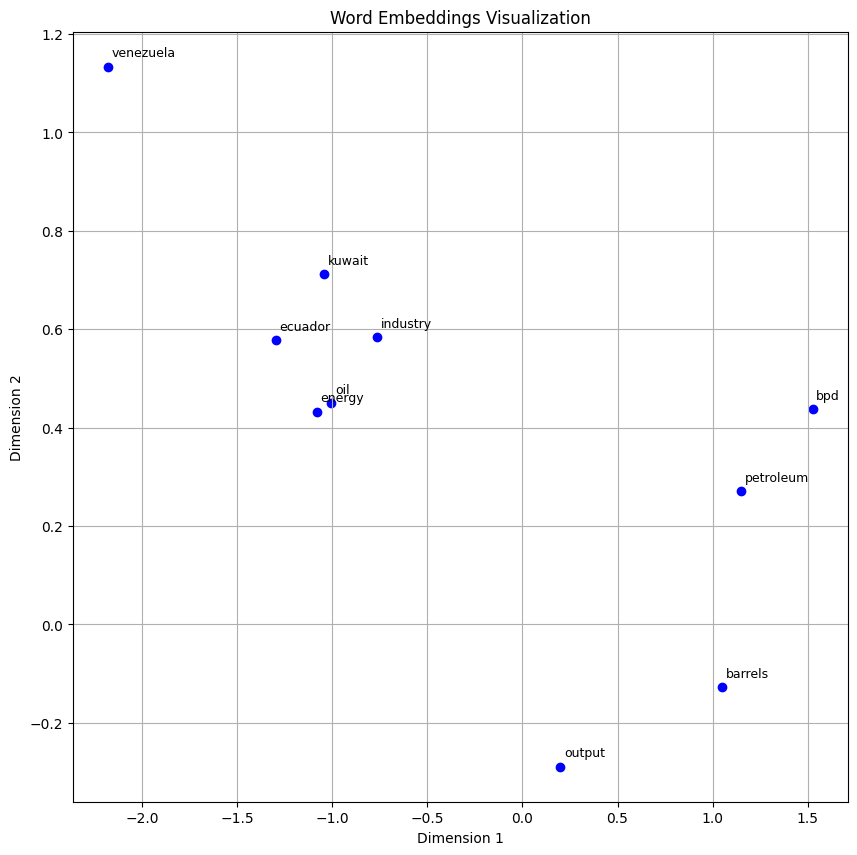

In [41]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

**<font color="red">[Task]</font>**:Write your answer here. <br> In the 2D plot, "oil", "industry", and "energy" cluster tightly together, but the country names: "ecuador", "kuwait", "venezuela" are much further apart despite all of them relying heavily on oil exports. <br><br>Word embeddings learn from large, general corpora and not specifically the oil industry context. Thus, the country names may not be clustered together because they do not appear together frequently in general language, <br><br> Compared to the co-occurrence matrix, the 2D word2vec plot shows more distinct clusters and meaningful data. Co-occurence matrix depends on solely on the frequency of word counts while word2vec uses algorithms to predict central words and capture the patterns.

### 2.2 Polysemous Words
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings. For example, "leaves" has both "turns" and "ground" in the top 10, and "scoop" has both "buckets" and "pops". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the GenSim [documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar).

In [23]:

# ------------------
# Write your polysemous word exploration code here.

wv_from_bin.most_similar("bow")

# ------------------

[('ring', 0.8987284302711487),
 ('coat', 0.8937269449234009),
 ('diamond', 0.8877973556518555),
 ('hair', 0.8825303912162781),
 ('wig', 0.880562424659729),
 ('purple', 0.8794164657592773),
 ('wrap', 0.8728375434875488),
 ('bottom', 0.8693719506263733),
 ('dress', 0.8653069734573364),
 ('shirt', 0.8640713095664978)]

**<font color="red">[Task]</font>**:Write your answer here.
<br> Word: Bow
<br> Word2Vec assigns one vector to each word type. 
<br> If a particular definition/meaning of the word is more frequent in the training data, the vector will reflect that definition. The pretrained model (glove-twitter-25) from gensim is also trained on Twitter data. The vector captures the definition most frequently used on the platform.

### 2.3: Synonyms & Antonyms

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.


In [24]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "fast"
w2 = "rapid"
w3 = "slow"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms fast, rapid have cosine distance: 0.5072828531265259
Antonyms fast, slow have cosine distance: 0.19635295867919922


**<font color="red">[Task]</font>**:Write your answer here.
<br>
<br>Synonyms: fast, rapid have cosine distance: 0.507
<br>Antonyms: fast, slow have cosine distance: 0.196
<br> The model shows that "fast" is closer to "slow", an antonym instead of "rapid", a synonym which is counterintuitive. 
<br> This occurs because the word embeddings are based on distributional hypothesis where words used in similar contexts have similar vectors. "fast" and "slow" may appear more frequently in the same contexts as compared to "fast" and "rapid". 
<br> Another reason is that antonyms could cluster together as they describe the same context but in opposite directions

## Task 3: Utilize Word Embeddings

Guess, you've seen such pictures already:  

![Embeddings Relations](https://www.tensorflow.org/images/linear-relationships.png)
*Source: [Tensorflow tutorial on Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)*

In the first image, we observe the intricate relationships encoded within the word embeddings space. This encompasses various dimensions like gender differences (male-female) or verb tenses.

**Interactive Exploration**

To delve deeper and interactively explore these relationships, check out these resources:
- [Word Vector Demo](http://bionlp-www.utu.fi/wv_demo/)
- [Word2Viz](https://lamyiowce.github.io/word2viz/)

These tools offer a playful yet insightful experience, allowing you to grasp the nuances and capabilities of word embeddings.

**Our task point**

Our focus will be on utilizing [gensim](https://radimrehurek.com/gensim/), a well-regarded Python library for word embeddings. Gensim makes it effortless to work with and leverage the power of word embeddings in various applications.


### **3.1 Use Pretrained Embeddings**
Base on gensim, we can easily use a well-pretrained embeddings model. There are a number of such models in <font color="blue">gensim</font>, you can call `api.info()` to get the list.

In [25]:
import gensim.downloader as api

model = api.load('glove-twitter-25')

**use word embedidngs with gensim**

Yay, we have loaded well-built word embedings models, now let's learn how to use it.

1. To get word's vector, well, call `get_vector`:

In [26]:
model.get_vector('anything')

array([ 0.47841 ,  0.39537 , -0.3216  ,  0.58639 , -0.48316 ,  0.11402 ,
        1.3829  , -0.86081 , -0.81769 , -0.075026, -0.77716 ,  0.58212 ,
       -5.2756  , -0.54024 ,  0.39019 ,  0.3941  ,  0.32682 , -0.7274  ,
        0.49747 , -0.88427 , -0.062516,  0.035716, -0.28677 ,  0.64153 ,
       -0.574   ], dtype=float32)

2. To get most similar words for the given one :

In [27]:
model.most_similar('bread')

[('meat', 0.9616429209709167),
 ('corn', 0.9610626101493835),
 ('cheese', 0.9532766342163086),
 ('noodles', 0.9493104815483093),
 ('soup', 0.9440536499023438),
 ('egg', 0.9418217539787292),
 ('milk', 0.941437304019928),
 ('chicken', 0.9398934245109558),
 ('beans', 0.939075231552124),
 ('toast', 0.936586856842041)]

3. Analogies with word embeddings

It can do such magic (`woman` + `grandfather` - `man`) :


In [28]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
model.most_similar(positive=['woman', 'grandfather'], negative=['man'])

[('grandmother', 0.878795325756073),
 ('deceased', 0.8756000399589539),
 ('grandson', 0.8732503652572632),
 ('granddaughter', 0.8626090288162231),
 ('mother-in-law', 0.8423668742179871),
 ('stabs', 0.8338027596473694),
 ('adopted', 0.8286494016647339),
 ('marries', 0.825094997882843),
 ('brother-in-law', 0.812983512878418),
 ('fiancee', 0.8020613193511963)]

And this too:

In [29]:
model.most_similar([model.get_vector('coder') - model.get_vector('brain') + model.get_vector('money')])

[('gfx', 0.8166244029998779),
 ('realtor', 0.7994467616081238),
 ('promoters', 0.7922900319099426),
 ('promoter', 0.7778065800666809),
 ('recruiter', 0.7722607254981995),
 ('digg', 0.770290732383728),
 ('sfi', 0.7655168175697327),
 ('chefs', 0.7650213241577148),
 ('smallbusiness', 0.7634385824203491),
 ('realestate', 0.7535584568977356)]

That is, who is like coder, with money and without brains.

**<font color="red">[Task]</font>** : Run an interesting analogy example

**Hint**: Similar to (`woman` + `grandfather` - `man`)

In [30]:
# ------------------
# Write your implementation here.

model.most_similar(positive=['woman','king'], negative=['man'])

# ------------------

[('meets', 0.8841923475265503),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131038546562195),
 ('father', 0.8115833401679993),
 ('soldier', 0.8111359477043152),
 ('mercy', 0.8082393407821655),
 ('hero', 0.8082264065742493)]

### **3.2 Finding the Most Similar Sentence**

In this section, we present a method for sentence retrieval based on word embeddings.

The key point is to construct *sentence embeddings*. The simplest method to obtain a sentence embedding is by averaging the embeddings of the words within the sentence.

*You are probably thinking, 'What a dumb idea, why on earth the average of embedding should contain any useful information'. Well, check [this paper](https://arxiv.org/pdf/1805.09843.pdf).*



1. Get Sentence Embedding

**<font color="red">[Task]</font>** : Implement a function to compute sentence embeddings.

**Hint**: Tokenize and lowercase the texts. Calculate the mean embedding for words with known embeddings.

In [31]:
def get_sentence_embedding(model, sentence):
    """ Calcs sentence embedding as a mean of known word embeddings in the sentence.
    If all the words are unknown, returns zero vector.
    :param model: KeyedVectors instance
    :param sentence: str or list of str (tokenized text)
    """
    embedding = np.zeros([model.vector_size], dtype='float32')

    if isinstance(sentence, str):
        words = word_tokenize(sentence.lower())
    else:
        words = sentence

    sum_embedding = np.zeros([model.vector_size], dtype='float32')
    words_in_model = 0

    # ------------------
    # Write your implementation here.
    for word in words:
        if word in model:
            sum_embedding += model[word]
            words_in_model += 1

    if words_in_model > 0:
        sum_embedding = sum_embedding / words_in_model
        
    return sum_embedding
    # ------------------

Check it:

In [32]:
vector = get_sentence_embedding(model, "I'm very sure. This never happened to me before...")
assert vector.shape == (model.vector_size,)

2. **Building the Index**

With our method ready, we can now embed all sentences in our corpus for retrieval purposes. In this case, we use data from Quora, sampling 1000 entries randomly, and converting them into sentence embeddings.

In [33]:
quora_data = pd.read_csv('train.csv')
corpus = list(quora_data.sample(1000)[['question1']].question1.replace(np.nan, '', regex=True).unique())
text_vectors = np.array([get_sentence_embedding(model, sentence) for sentence in corpus])

In [34]:
corpus[0]

'Can you change your team on Pokemon Go?'

3. **Search**

Now we are able perform search of the nearest neighbours to the given sentences in our base!


We'll use cosine similarity of two vectors:
$$\text{cosine_similarity}(x, y) = \frac{x^{T} y}{||x||\cdot ||y||}$$

*It's not a [distance](https://www.encyclopediaofmath.org/index.php/Metric) strictly speaking but we still can use it to search for the sentence vectors.*

**<font color="red">[Task]</font>** : IImplement the following function.

**Hint:** Calc the similarity between `query` embedding and `text_vectors` using `cosine_similarity` function. Find `k` vectors with highest scores and return corresponding texts from `texts` list.

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest(model, text_vectors, texts, query, k=10):
    query_vec = get_sentence_embedding(model, query)

    # ------------------
    # Write your implementation here.
    similarity = cosine_similarity([query_vec], text_vectors)[0]
    top_k = np.argsort(similarity)[-k:]
    return [texts[index] for index in top_k]
    # ------------------

Check it!

In [36]:
find_nearest(model, text_vectors, corpus, "What's your biggest regret in life?", k=10)

['Why men take so much time in accepting marriage? Even when they are in physical relationship with you?',
 'How do you build the habit of hard work for something you really want in life?',
 'Suicide: What is the most quick and effective way to kill yourself?',
 'What is the difference between loving someone and being in love with them?',
 'How does it feel when a person has sex for the very first time?',
 'What is the difference a day make?',
 'What is the worst thing done to you by your manager?',
 'Why is your voice different when you speak a different language? And is there a difference in this effect between bilingual beings and ones that learn a second language later?',
 'What is the best habit that can do wonders for everyone?',
 "What is the largest amount of money that you have ever 'found', and what did you do with it?"]

### **Bias of Word Embeddings**

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.



Here's an example showing word embeddings biases on gender:

In [37]:
print(model.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(model.most_similar(positive=['woman', 'profession'], negative=['man']))

[('maths', 0.7983576059341431), ('basis', 0.7973601818084717), ('humør', 0.7948898673057556), ('cert', 0.7902684211730957), ('mulig', 0.7874146699905396), ('spændende', 0.7728655338287354), ('dårligt', 0.7700906991958618), ('latter', 0.7676339745521545), ('noget', 0.7676041722297668), ('vet', 0.7675378918647766)]

[('representation', 0.871566116809845), ('encourages', 0.8626720309257507), ('empowering', 0.8612703084945679), ('intellectual', 0.8564386963844299), ('influences', 0.8559868931770325), ('ethical', 0.8550472259521484), ('affairs', 0.8541139960289001), ('behaviors', 0.8481355905532837), ('advocacy', 0.8439522981643677), ('critic', 0.8406821489334106)]


**<font color="red">[Task]</font>** Identify an example of bias.

**Hint:** Consider providing an example from perspectives such as race or sexual orientation.

In [38]:
# ------------------
# Write your implementation here.
print(model.most_similar(positive=['nurse', 'she'], negative=['he']))
# ------------------

[('receptionist', 0.8576032519340515), ('therapist', 0.8499090671539307), ('librarian', 0.8328267931938171), ('nursing', 0.8249308466911316), ('pharmacist', 0.8094512820243835), ('counselor', 0.8069541454315186), ('housekeeping', 0.7940718531608582), ('icu', 0.7914223074913025), ('mechanic', 0.7811599373817444), ('nurses', 0.7791796326637268)]


**<font color="red">[Task]</font>** Thinking About Bias.

**Hint:** Briefly explain how bias can be introduced into word embeddings and suggest one method to mitigate these biases.

**<font color="red">Write your answer here.</font>**
<br>
Word embeddings inherit the biases from the corpora that they are trained on. If the stereotypes and biases is very skewed in the corpora (due to political or historical reasons), it will be captured into the vectors.
One method is to use modern models such as BERT that can look at the left and right contexts to get a more accurate representation of the word and the meaning of the sentence.


## Supplementary Materials
Source from [DeepNLP-Course of DanAnastasyev](https://colab.research.google.com/drive/1o65wrq6RYgWyyMvNP8r9ZknXBniDoXrn#forceEdit=true&offline=true&sandboxMode=true)

## To read
### Blogs
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[On word embeddings - Part 2: Approximating the Softmax, Sebastian Ruder](http://ruder.io/word-embeddings-softmax/index.html)  
[Word2Vec Tutorial - The Skip-Gram Model, Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)  
[Word2Vec Tutorial Part 2 - Negative Sampling, Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)

### Papers
[Word2vec Parameter Learning Explained (2014), Xin Rong](https://arxiv.org/abs/1411.2738)  
[Neural word embedding as implicit matrix factorization (2014), Levy, Omer, and Yoav Goldberg](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)  

### Enhancing Embeddings
[Two/Too Simple Adaptations of Word2Vec for Syntax Problems (2015), Ling, Wang, et al.](https://www.aclweb.org/anthology/N/N15/N15-1142.pdf)  
[Not All Neural Embeddings are Born Equal (2014)](https://arxiv.org/pdf/1410.0718.pdf)  
[Retrofitting Word Vectors to Semantic Lexicons (2014), M. Faruqui, et al.](https://arxiv.org/pdf/1411.4166.pdf)  
[All-but-the-top: Simple and Effective Postprocessing for Word Representations (2017), Mu, et al.](https://arxiv.org/pdf/1702.01417.pdf)  

### Sentence Embeddings
[Skip-Thought Vectors (2015), Kiros, et al.](https://arxiv.org/pdf/1506.06726)  

### Backpropagation
[Backpropagation, Intuitions, cs231n + next parts in the Module 1](http://cs231n.github.io/optimization-2/)   
[Calculus on Computational Graphs: Backpropagation, Christopher Olah](http://colah.github.io/posts/2015-08-Backprop/)

## To watch
[cs224n "Lecture 2 - Word Vector Representations: word2vec"](https://www.youtube.com/watch?v=ERibwqs9p38&index=2&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)  
[cs224n "Lecture 5 - Backpropagation"](https://www.youtube.com/watch?v=isPiE-DBagM&index=5&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)   



## Acknowledgement

This assignment was developed with reference to the following course materials:
- [DeepNLP Course by Dan Anastasyev](https://github.com/DanAnastasyev/DeepNLP-Course?tab=readme-ov-file)
- [Exploring Word Vectors from Stanford's CS224N](https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html)
- [Natural Language Processing course from Princeton University](https://nlp.cs.princeton.edu/cos484-sp21/)
- [Yandex Data School NLP Course Week 1 Seminar](https://colab.research.google.com/github/yandexdataschool/nlp_course/blob/2023/week01_embeddings/seminar.ipynb#scrollTo=9m7GZWVk-jrW)
